In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import zscore

file_path = "/content/sample_data/vatsalya dataset new.csv"
df = pd.read_csv(file_path)

df.fillna({
    'Gender': df['Gender'].mode()[0],
    'Product': df['Product'].mode()[0],
    'Age': df['Age'].median(),
    'Total Customer Spent Value': df['Total Customer Spent Value'].median()
}, inplace=True)

numeric_cols = ['Age', 'Total Customer Spent Value']
df = df[(np.abs(zscore(df[numeric_cols])) < 3).all(axis=1)]

df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

label_encoder = LabelEncoder()
df['Product'] = label_encoder.fit_transform(df['Product'])

df['Customer ID'] = df['Customer Name'].apply(lambda x: hash(x))
df.drop(columns=['Customer Name'], inplace=True)

scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

df['Age'] = scaler_standard.fit_transform(df[['Age']])
df['Total Customer Spent Value'] = scaler_minmax.fit_transform(df[['Total Customer Spent Value']])

df.to_csv("preprocessed_dairy_dataset_optimized.csv", index=False)

print("Preprocessing Completed. Saved as 'preprocessed_dairy_dataset_optimized.csv'.")


Preprocessing Completed. Saved as 'preprocessed_dairy_dataset_optimized.csv'.


**Customer Segmentation**

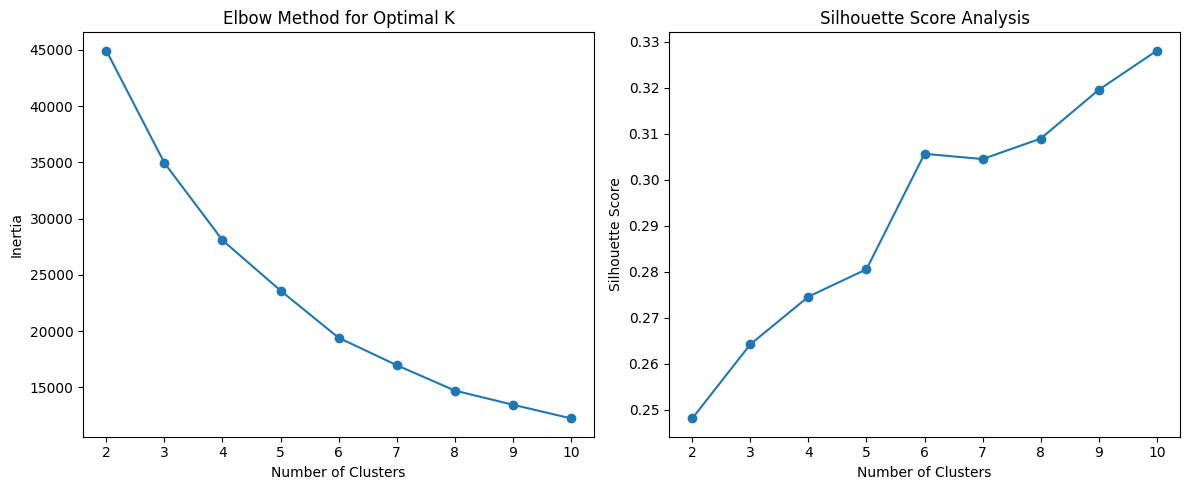

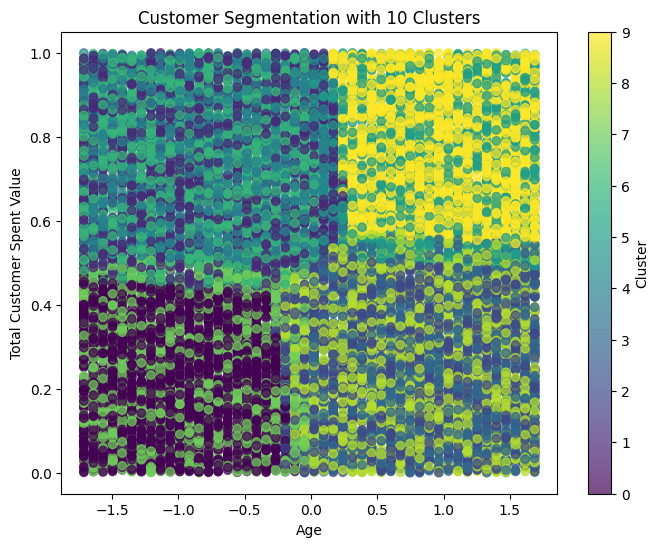

   Gender       Age            Area      City  Pincode  Product  \
0       0  0.819163     Rajarampuri  Kolhapur   416008        0   
1       1  1.180955  Mangalwar Peth  Kolhapur   416010        2   
2       1  1.108596  Rukhmini Nagar  Kolhapur   416013        2   
3       1  0.674446  Rukhmini Nagar  Kolhapur   416013        0   
4       1 -0.772723    Shivaji Peth  Kolhapur   416012        1   

   Total Customer Spent Value          Customer ID  Customer Segment  
0                    0.696061  8405876732091136628                 9  
1                    0.187475   109635002320286066                 2  
2                    0.831515 -4255691050585587739                 5  
3                    0.428485 -6487017087573676841                 3  
4                    0.552121   109635002320286066                 1  


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("preprocessed_dairy_dataset_optimized.csv")

features = df[['Age', 'Total Customer Spent Value', 'Product']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Customer Segment'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["Age"], df["Total Customer Spent Value"], c=df["Customer Segment"], cmap="viridis", alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Total Customer Spent Value")
plt.title(f"Customer Segmentation with {optimal_k} Clusters")
plt.colorbar(scatter, label="Cluster")
plt.show()

print(df.head())


**Delivery Route Optimization using A* Algorithm**

In [ ]:
import networkx as nx
import heapq

delivery_locations = {
    'Rajarampuri': {'Mangalwar Peth': 2, 'Shivaji Peth': 4},
    'Mangalwar Peth': {'Rukhmini Nagar': 3, 'Shivaji Peth': 1},
    'Rukhmini Nagar': {'Shivaji Peth': 5, 'Rajarampuri': 6},
    'Shivaji Peth': {'Rukhmini Nagar': 2}
}

graph = nx.Graph()
for src, destinations in delivery_locations.items():
    for dest, distance in destinations.items():
        graph.add_edge(src, dest, weight=distance)

def a_star_algorithm(graph, start, goal):
    def heuristic(node, goal):
        return 0  # Dummy heuristic as actual geographic distances are unknown

    open_list = []
    heapq.heappush(open_list, (0, start))
    g_costs = {node: float('inf') for node in graph.nodes}
    g_costs[start] = 0
    came_from = {}

    while open_list:
        _, current = heapq.heappop(open_list)

        if current == goal:
            path = []
            while current in came_from:
                path.insert(0, current)
                current = came_from[current]
            path.insert(0, start)
            return path

        for neighbor in graph.neighbors(current):
            tentative_g_score = g_costs[current] + graph[current][neighbor]['weight']

            if tentative_g_score < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_score
                came_from[neighbor] = current
                heapq.heappush(open_list, (tentative_g_score + heuristic(neighbor, goal), neighbor))

    return None

destinations = list(delivery_locations.keys())
optimal_routes = {}

for destination in destinations:
    if destination != 'Rajarampuri':
        optimal_routes[destination] = a_star_algorithm(graph, 'Rajarampuri', destination)

print("Optimal Delivery Routes from Rajarampuri:")
for destination, path in optimal_routes.items():
    print(f"{destination}: {path}")

Optimal Delivery Routes from Rajarampuri:
Mangalwar Peth: ['Rajarampuri', 'Mangalwar Peth']
Rukhmini Nagar: ['Rajarampuri', 'Mangalwar Peth', 'Rukhmini Nagar']
Shivaji Peth: ['Rajarampuri', 'Mangalwar Peth', 'Shivaji Peth']


**Customer Spending Behavior Prediction**

                        MSE  R² Score
Ridge Regression   0.084999 -0.000034
Lasso Regression   0.085003 -0.000070
Random Forest      0.085511 -0.006053
Gradient Boosting  0.085373 -0.004432
AdaBoost           0.084972  0.000287
XGBoost            0.085381 -0.004524


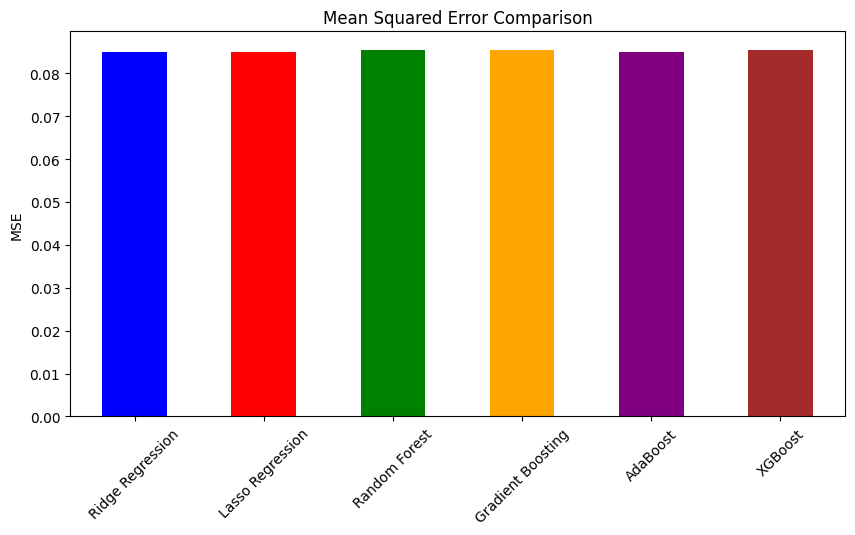

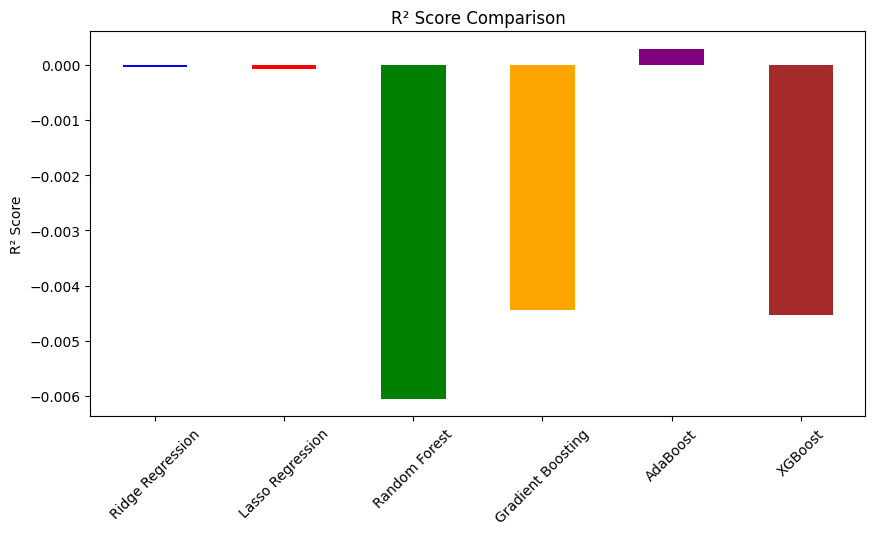

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

df = pd.read_csv("preprocessed_dairy_dataset_optimized.csv")

X = df[['Age', 'Product']]
y = df['Total Customer Spent Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R² Score": r2}

df_results = pd.DataFrame(results).T
print(df_results)

plt.figure(figsize=(10, 5))
df_results["MSE"].plot(kind="bar", color=['blue', 'red', 'green', 'orange', 'purple', 'brown'])
plt.title("Mean Squared Error Comparison")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
df_results["R² Score"].plot(kind="bar", color=['blue', 'red', 'green', 'orange', 'purple', 'brown'])
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.show()

**Time-Series Forecasting for Demand Prediction**



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


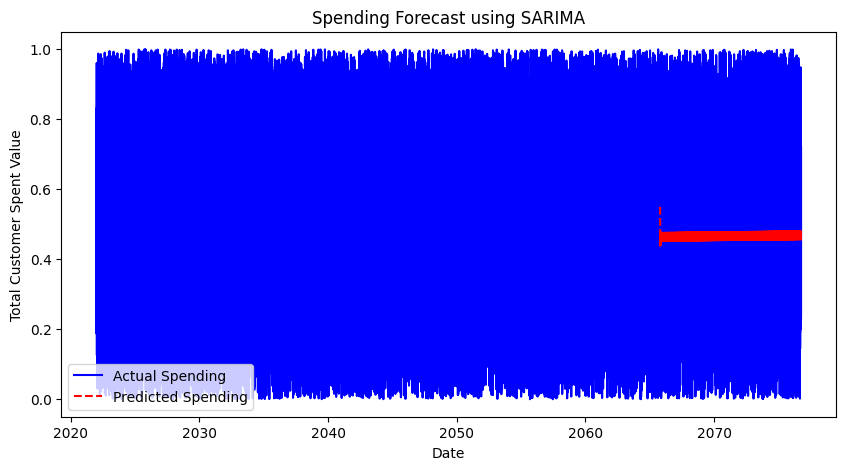

30-Day Spending Forecast:
 2065-10-22    0.55
2065-10-23    0.44
2065-10-24    0.52
2065-10-25    0.48
2065-10-26    0.45
2065-10-27    0.44
2065-10-28    0.47
2065-10-29    0.46
2065-10-30    0.48
2065-10-31    0.48
2065-11-01    0.48
2065-11-02    0.47
2065-11-03    0.45
2065-11-04    0.47
2065-11-05    0.47
2065-11-06    0.47
2065-11-07    0.47
2065-11-08    0.48
2065-11-09    0.47
2065-11-10    0.45
2065-11-11    0.47
2065-11-12    0.47
2065-11-13    0.47
2065-11-14    0.47
2065-11-15    0.48
2065-11-16    0.47
2065-11-17    0.45
2065-11-18    0.47
2065-11-19    0.47
2065-11-20    0.47
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

df = pd.read_csv("preprocessed_dairy_dataset_optimized.csv")

df['Date'] = pd.date_range(start='1/1/2022', periods=len(df), freq='D')
df.set_index('Date', inplace=True)

df_spending = df[['Total Customer Spent Value']]

train_size = int(len(df_spending) * 0.8)
train, test = df_spending.iloc[:train_size], df_spending.iloc[train_size:]

model = SARIMAX(train, order=(5, 1, 2), seasonal_order=(1, 1, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(10, 5))
plt.plot(df_spending.index, df_spending, label="Actual Spending", color="blue")
plt.plot(test.index, forecast, label="Predicted Spending", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Total Customer Spent Value")
plt.title("Spending Forecast using SARIMA")
plt.legend()
plt.show()

future_forecast = model_fit.forecast(steps=30)
print("30-Day Spending Forecast:\n", np.round(future_forecast, 2))


**Ethical Data Handling & Security Measures**

In [ ]:
from cryptography.fernet import Fernet

# Generate a key for encryption
key = Fernet.generate_key()
cipher_suite = Fernet(key)

# Encrypt sensitive data (e.g., Customer ID)
df['Encrypted Customer ID'] = df['Customer ID'].apply(lambda x: cipher_suite.encrypt(str(x).encode()).decode())

# Save encrypted dataset
df.to_csv("secure_dairy_dataset.csv", index=False)

print("Customer data securely encrypted and saved as 'secure_dairy_dataset.csv'.")


Customer data securely encrypted and saved as 'secure_dairy_dataset.csv'.


**Dashboard Development using Flask**

Age vs Spending – Understand how spending varies with age.

Product Distribution – See which dairy products are most popular.

Age vs Product Preferences – Find out what people of different age groups are buying.

Location-wise Product Preferences – Understand the demand across different areas.

Gender-based Spending Trends – Analyze spending behavior by gender.

Customer Segments Distribution – Visualize the clusters formed in segmentation.

Pincode-based Sales Analysis – Identify high-demand locations. **bold text**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed dataset
df = pd.read_csv("customer_segmentation_results.csv")

# Convert categorical columns to string (to avoid issues)
df['Product'] = df['Product'].astype(str)
df['Area'] = df['Area'].astype(str)

# Set visual style
sns.set_theme(style="whitegrid")

# Create subplots for multiple graphs
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle("Dairy Delivery System Insights", fontsize=16)

# 📊 1. Age vs Spending Scatter Plot
sns.scatterplot(x=df["Age"], y=df["Total Customer Spent Value"], hue=df["Gender"], ax=axes[0, 0])
axes[0, 0].set_title("Age vs Spending")

# 📊 2. Product Distribution
sns.countplot(x=df["Product"], palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Popular Dairy Products")

# 📊 3. Age vs Product Preferences
sns.boxplot(x=df["Product"], y=df["Age"], ax=axes[0, 2])
axes[0, 2].set_title("Age-wise Product Preferences")

# 📊 4. Location-wise Product Preferences
sns.countplot(y=df["Area"], hue=df["Product"], ax=axes[1, 0])
axes[1, 0].set_title("Product Demand Across Locations")

# 📊 5. Gender-based Spending Trends
sns.boxplot(x=df["Gender"], y=df["Total Customer Spent Value"], ax=axes[1, 1])
axes[1, 1].set_title("Spending by Gender")

# 📊 6. Customer Segments Distribution
sns.histplot(df["Customer Segment"], kde=True, bins=5, ax=axes[1, 2])
axes[1, 2].set_title("Customer Segments Distribution")

# 📊 7. Pincode-wise Sales Analysis
sns.barplot(x=df["Pincode"], y=df["Total Customer Spent Value"], ax=axes[2, 0])
axes[2, 0].set_title("Sales Analysis by Pincode")
axes[2, 0].tick_params(axis='x', rotation=45)

# 📊 8. Correlation Heatmap (Exclude non-numeric columns)
numeric_df = df.select_dtypes(include=['number'])  # Only keep numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", ax=axes[2, 1])
axes[2, 1].set_title("Correlation Heatmap")

# 📊 9. Spending per Product Category
sns.boxplot(x=df["Product"], y=df["Total Customer Spent Value"], ax=axes[2, 2])
axes[2, 2].set_title("Spending Per Product Category")

# Adjust layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
